#### EDA and Visualization Final Project: Data Prep and Analysis
###### Zachary Barnes and Bing Wang

##### Housekeeping

In [2]:
# Load Python libraries
import os
import numpy as np
import pandas as pd

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

##### Read in and organize data (Collisions and Victims datasets, from TIMS)

In [3]:
c = pd.read_csv("Collisions.csv")

# Keep only relevant columns
c = c[['CASE_ID','INTERSECTION','COLLISION_SEVERITY',
        'LIGHTING','LOCATION_TYPE','MVIW','TYPE_OF_COLLISION',
        'WEATHER_1','LATITUDE','LONGITUDE','PRIMARY_RD',
        'SECONDARY_RD','POINT_X','POINT_Y']]
c.sample(5)

,CASE_ID,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y
1443,8698534,N,4,C,NaN,C,D,A,NaN,NaN,MISSION ST,ANTHONY ST,-122.399355,37.788361
2169,8639090,Y,3,A,NaN,C,D,A,NaN,NaN,FOLSOM ST,25TH ST,-122.413940,37.750920
1972,8656370,N,4,A,NaN,G,D,A,NaN,NaN,CLAY ST,BATTERY ST,-122.400863,37.794936
2820,8594806,N,4,C,NaN,G,C,A,NaN,NaN,9TH ST,MARKET ST,-122.415766,37.777054
3528,90764740,N,4,A,NaN,C,C,B,37.72195,-122.40035,US-101 N/B,PAUL AVE U/C,-122.400369,37.721943


In [4]:
v = pd.read_csv('Victims.csv')

# Keep only relevant columns
v = v[['CASE_ID','VICTIM_DEGREE_OF_INJURY','VICTIM_ROLE','VICTIM_AGE']]
v.sample(5)


,CASE_ID,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
3090,8636992,0,2,41
3663,8617240,3,4,38
4134,8594574,0,2,19
2704,8656390,4,4,28
4162,8594241,4,1,38


In [5]:
# Merge Collisions and Victims datasets
cv = pd.merge(c, v, how='left', on='CASE_ID')
cv.sample(5)

,CASE_ID,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
1741,8718746,N,3,C,NaN,B,G,A,NaN,NaN,FOLSOM ST,PRECITA AV,-122.413546,37.746757,3,3,17
1313,8754840,Y,3,A,NaN,G,F,A,NaN,NaN,ALEMANY BL,COTTER ST,-122.435020,37.728200,0,2,15
5231,8552811,N,3,A,NaN,I,F,A,NaN,NaN,3RD ST,16TH ST,-122.389088,37.765688,3,1,33
2642,8685710,Y,4,A,NaN,C,A,A,NaN,NaN,S VAN NESS AV,13TH ST,-122.417770,37.769720,4,2,48
2928,8664179,Y,4,B,NaN,C,D,A,NaN,NaN,FELL ST,SHRADER ST,-122.452410,37.772150,4,2,11


In [6]:
# Paul's Function to remove NaNs from columns
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [7]:
# Convert NaNs to string type
cv = fixDFcolsForR(cv)
cv.sample(5)

,CASE_ID,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
946,8758263,Y,4,C,nan,B,G,C,NaN,NaN,GEARY ST,KEARNY ST,-122.40351,37.78795,4,3,70
1842,8716533,Y,3,C,nan,C,D,A,NaN,NaN,FOLSOM ST,19TH ST,-122.41482,37.76049,4,2,27
3396,8637023,Y,4,A,nan,C,D,C,NaN,NaN,WEBSTER ST,UNION ST,-122.43384,37.79730,4,2,77
1125,8758094,Y,4,A,nan,-,D,A,NaN,NaN,3RD ST,LE CONTE AV,-122.39757,37.71887,0,2,998
826,8763985,Y,4,A,nan,B,G,B,NaN,NaN,CHURCH ST,17TH ST,-122.42851,37.76288,4,3,83


#### Trying out logistic regression

In [8]:
# from: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [13]:
# make "fatal or not" binary variable for Y
cv.loc[cv.VICTIM_DEGREE_OF_INJURY == 1, "Fatal"] = 1
cv.loc[cv.VICTIM_DEGREE_OF_INJURY != 1, "Fatal"] = 0
cv.head()

,CASE_ID,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,Fatal
0,90736476,N,4,A,nan,C,C,B,37.73747,-122.40784,US-101 N/B,ALEMANY BLVD U/C,-122.407801,37.737483,7,1,24,0.0
1,90736282,N,3,A,nan,C,C,A,37.73841,-122.40775,I-280 N/B TO US-101 N/B,CORTLAND AVENUE UNDER-CROSSING,NaN,NaN,7,2,27,0.0
2,90736282,N,3,A,nan,C,C,A,37.73841,-122.40775,I-280 N/B TO US-101 N/B,CORTLAND AVENUE UNDER-CROSSING,NaN,NaN,6,1,43,0.0
3,90735985,N,4,A,R,C,C,A,37.78522,-122.39317,I-80 E/B FROM ESSEX ST.,ESSEX ST,-122.393170,37.785220,7,1,38,0.0
4,90735985,N,4,A,R,C,C,A,37.78522,-122.39317,I-80 E/B FROM ESSEX ST.,ESSEX ST,-122.393170,37.785220,7,2,19,0.0


In [17]:
import statsmodels.api as sm
logit_model=sm.Logit(cv.Fatal, cv.VICTIM_AGE)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.092017
         Iterations 10
                         Results: Logit
Model:              Logit            Pseudo R-squared: -2.389   
Dependent Variable: Fatal            AIC:              1098.6633
Date:               2019-09-28 17:32 BIC:              1105.3559
No. Observations:   5959             Log-Likelihood:   -548.33  
Df Model:           0                LL-Null:          -161.79  
Df Residuals:       5958             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     10.0000                                     
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
VICTIM_AGE  -0.1469    0.0046  -31.7286  0.0000  -0.1560  -0.1379



In [89]:
# model fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = cv.VICTIM_AGE
y = cv.Fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
# warning: need to reshape X_train?
X_train = np.array(X_train).reshape(-1,1)
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

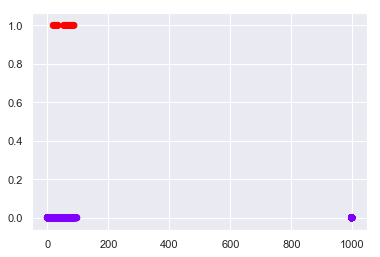

In [90]:
plt.scatter(X_train, y_train, c=y_train, cmap='rainbow')

In [91]:
# print coefficients
print(logreg.coef_)
print(logreg.intercept_)

[[-0.00195549]]
[-5.22874678]


In [97]:
# test model again data it hasn't seen yet
# need to reshape X_test?
X_test = np.array(X_test).reshape(-1,1)
y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)
# Matrix: True positive, true negative; 
#         False positive, false negative

array([[   0, 1778],
       [   0,   10]])

In [98]:
logreg.predict_proba(X_test)

array([[0.99470966, 0.00529034],
       [0.9950579 , 0.0049421 ],
       [0.99513424, 0.00486576],
       ...,
       [0.99499013, 0.00500987],
       [0.9949608 , 0.0050392 ],
       [0.99500959, 0.00499041]])

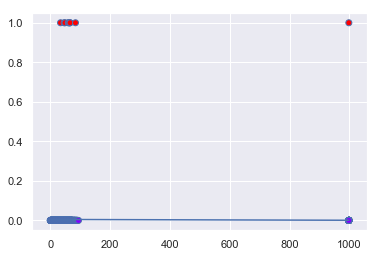

In [99]:
# graph it out
df = pd.DataFrame({'X': X_test[:,0], 'y': y_test})
df = df.sort_values(by='X')


from scipy.special import expit
sigmoid_function = expit(df['X'] * logreg.coef_[0][0] + logreg.intercept_[0]).ravel()
plt.plot(df['X'], sigmoid_function)
plt.scatter(df['X'], df['y'], c=df['y'], cmap='rainbow', edgecolors='b')

In [70]:
# from: https://towardsdatascience.com/logistic-regression-python-7c451928efee

# Try with made up dataset
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [71]:
# generate dataset
x, y = make_classification(
    n_samples=100,
    n_features=1,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.03,
    n_informative=1,
    n_redundant=0,
    n_repeated=0
)

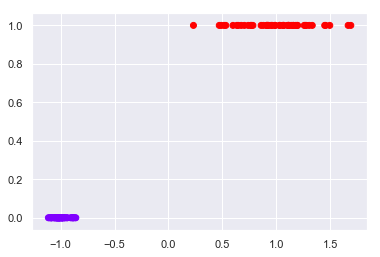

In [72]:
plt.scatter(x, y, c=y, cmap='rainbow')

In [73]:
# split data into data to train model and data to test model
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [74]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [75]:
# print coefficients
print(lr.coef_)
print(lr.intercept_)

[[3.18163247]]
[0.1381381]


In [76]:
# test model again data it hasn't seen yet
y_pred = lr.predict(x_test)
confusion_matrix(y_test, y_pred)
# Matrix: True positive, true negative; 
#         False positive, false negative

array([[11,  0],
       [ 0, 14]])

In [78]:
# predict for each observation in x_test:
# probability it belongs to first class, vs. second class
lr.predict_proba(x_test)

array([[0.07052982, 0.92947018],
       [0.95567555, 0.04432445],
       [0.95236174, 0.04763826],
       [0.06738908, 0.93261092],
       [0.96573342, 0.03426658],
       [0.94972767, 0.05027233],
       [0.07655715, 0.92344285],
       [0.96075586, 0.03924414],
       [0.03632074, 0.96367926],
       [0.00433389, 0.99566611],
       [0.04552518, 0.95447482],
       [0.02812739, 0.97187261],
       [0.01516202, 0.98483798],
       [0.95250293, 0.04749707],
       [0.02462784, 0.97537216],
       [0.95289792, 0.04710208],
       [0.95829138, 0.04170862],
       [0.03194672, 0.96805328],
       [0.08491096, 0.91508904],
       [0.95334904, 0.04665096],
       [0.00400903, 0.99599097],
       [0.96454729, 0.03545271],
       [0.01565165, 0.98434835],
       [0.95184964, 0.04815036],
       [0.16294366, 0.83705634]])

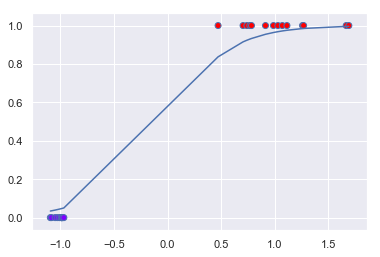

In [79]:
# graph it out
df = pd.DataFrame({'x': x_test[:,0], 'y': y_test})
df = df.sort_values(by='x')


from scipy.special import expit
sigmoid_function = expit(df['x'] * lr.coef_[0][0] + lr.intercept_[0]).ravel()
plt.plot(df['x'], sigmoid_function)
plt.scatter(df['x'], df['y'], c=df['y'], cmap='rainbow', edgecolors='b')